In [106]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import re


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
scaler = StandardScaler()

In [288]:
# Load data
clean_data = pd.read_csv('data/Ames_HousePrice_cleaned.csv')
address_data = pd.read_csv('data/Ames_HousePrice_Address.csv')
city = gpd.read_file("data/city.geojson")
roads = gpd.read_file("data/roads.geojson")
park = gpd.read_file("data/park.geojson")

roads_df = roads[['highway','geometry']]
roads_motor = roads_df[roads_df['highway']=='motorway']
roads_primary = roads_df[roads_df['highway']=='primary']
roads_secondary = roads_df[roads_df['highway']=='secondary']
# roads_tertiary = roads_df[roads_df['highway']=='tertiary']
# roads_residential = roads_df[roads_df['highway']=='residential']

In [289]:
# Geographic feature engineering
clean_data = clean_data.merge(address_data[['PID', 'Longitude', 'Latitude']], on = 'PID')
clean_data = clean_data[~clean_data['Longitude'].isna()].copy()
clean_data = clean_data[clean_data['PID']!=908154205]
# clean_data[~clean_data.MSZoning.isin(list(['A', 'C', 'FV', 'I']))]

clean_data_cluster = clean_data[['Longitude', 'Latitude']]

mainlocs = {"LincolnGrand" : (42.0228613,-93.6202381),
            "LincolnSD" : (42.0229155,-93.6786829),
            "OntarioND" : (42.034549,-93.6787169),
            "Grand13" : (42.0345358,-93.6203941),
            "Grand24" : (42.0457363,-93.6205019),
            "GWHarrison" : (42.0594753,-93.6592406),
            "BloomStange" : (42.0563395,-93.6448835),
            "IC3069" : (42.0049608,-93.609927)}

for kw, val in mainlocs.items():
    dist = clean_data.apply(lambda x: distance.distance((x.loc['Latitude'],x.loc['Longitude']), val).miles, axis = 1)
    clean_data['gaudist_%s' %kw] = np.exp(-(dist/1.5)**2)
    
clean_data = clean_data[~clean_data['Longitude'].isna()]
# scaled_features = scaler.fit_transform(clean_data_cluster)
# kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
# kmeans.fit(scaled_features)
# clean_data['cluster'] = kmeans.labels_
# clean_data.to_csv('x_new.csv',index=False)

In [290]:
cl_y = clean_data['SalePrice']
cl_x = clean_data.drop(['PID','SalePrice','LandContour','LotShape','MSSubClass', 'PavedDrive',\
         'GarageType','CentralAir','Electrical','MoSold', 'YrSold','Neighborhood','Longitude', 'Latitude'], axis = 1)
# cl_x['QSF'] = clean_data['OverallQual']*clean_data['GrLivArea']

0.9210367190626861


,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageArea,PavedDrive,OurdoorSpace,MoSold,YrSold,YrMoSold,AgeSold,SaleCondition,Longitude,Latitude,gaudist_LincolnGrand,gaudist_LincolnSD,gaudist_OntarioND,gaudist_Grand13,gaudist_Grand24,gaudist_GWHarrison,gaudist_BloomStange,gaudist_IC3069,residual
1004,528351010,4316,755000,60,RL,21535,IR1,Lvl,Corner,NoRidge,1Fam,2Story,10,6,1994,1995,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,2444.0,Ex,Y,SBrkr,2444,1872,3,4,Ex,2,Attchd,832.0,Y,432,1,2007,2007.083333,12.083333,Normal,-93.657271,42.051980,0.033086,0.097507,0.305965,0.106042,0.187759,0.883821,0.801973,0.000663,-136073.770787
274,533350090,2944,150000,60,RL,24572,IR1,Lvl,CulDSac,Veenker,1Fam,2Story,9,3,1977,1977,BrkFace,1050.0,Gd,Gd,CBlock,Gd,TA,No,GLQ,410.0,Unf,0.0,994.0,TA,Y,SBrkr,1599,1345,2,3,Gd,1,Attchd,864.0,Y,226,6,2008,2008.500000,31.500000,Family,-93.655582,42.036729,0.153016,0.356301,0.527396,0.230609,0.198008,0.329187,0.387201,0.010151,-98839.672015
510,528108020,2042,253293,20,RL,12704,Reg,Lvl,Inside,NridgHt,1Fam,1Story,8,5,2008,2009,BrkFace,306.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,2042.0,Ex,Y,SBrkr,2042,0,2,3,Ex,1,Attchd,1390.0,Y,90,8,2009,2009.666667,0.666667,Partial,-93.654144,42.062992,0.008549,0.016429,0.088661,0.047169,0.140679,0.944858,0.823229,0.000080,-90381.309080
1730,535125010,2207,180000,20,RL,19900,Reg,Lvl,Inside,NAmes,1Fam,1Story,7,5,1970,1989,BrkFace,287.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,912.0,Unf,0.0,1947.0,TA,Y,SBrkr,2207,0,2,3,TA,1,Attchd,576.0,Y,301,7,2010,2010.583333,21.583333,Normal,-93.614307,42.049514,0.213244,0.001706,0.004727,0.595380,0.927418,0.075452,0.301778,0.014625,-79556.263755
1979,532478020,2014,275000,20,RL,15676,IR1,Low,Inside,Veenker,1Fam,1Story,8,8,1980,1980,BrkFace,115.0,Gd,Gd,CBlock,Gd,Gd,Gd,ALQ,1733.0,Rec,92.0,2014.0,Gd,Y,SBrkr,2014,0,2,2,Gd,2,Attchd,864.0,Y,717,4,2009,2009.333333,29.333333,Normal,-93.660327,42.037236,0.097420,0.435753,0.661534,0.150820,0.132820,0.350467,0.348836,0.005542,-76130.006128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,911370410,1652,392500,120,RM,5587,IR1,HLS,Inside,Crawfor,TwnhsE,1Story,8,5,2008,2008,Stone,186.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1480.0,Unf,0.0,1600.0,Ex,Y,SBrkr,1652,0,2,2,Gd,1,Attchd,482.0,Y,368,11,2008,2008.916667,0.916667,Partial,-93.616242,42.009326,0.665869,0.006866,0.002629,0.255180,0.059129,0.000553,0.003536,0.916398,93814.410483
56,528110070,1973,395000,20,RL,14226,Reg,Lvl,Corner,NridgHt,1Fam,1Story,8,5,2006,2006,BrkFace,375.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1935.0,Gd,Y,SBrkr,1973,0,2,3,Gd,1,Attchd,895.0,Y,360,7,2007,2007.583333,1.583333,Partial,-93.656286,42.062408,0.007910,0.020403,0.107000,0.042432,0.123165,0.971928,0.793868,0.000074,95793.715346
680,916252170,1295,230000,120,RM,8239,IR1,Lvl,Inside,GrnHill,TwnhsE,1Story,7,5,1986,1986,None,0.0,Gd,TA,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,Gd,Y,SBrkr,1295,0,2,2,Gd,0,Attchd,312.0,Y,0,11,2006,2006.916667,20.916667,Normal,-93.645586,42.000966,0.170079,0.099283,0.025225,0.043589,0.006846,0.000572,0.001515,0.216225,103151.038595
582,528150070,2364,611657,20,RL,12919,IR1,Lvl,Inside,NridgHt,1Fam,1Story,9,5,2009,2010,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,2330.0,Ex,Y,SBrkr,2364,0,2,2,Ex,2,Attchd,820.0,Y,67,3,2010,2010.250000,0.250000,Partial,-93.655051,42.059617,0.013761,0.029935,0.136811,0.064279,0.163393,0.979533,0.865636,0.000163,104237.445914


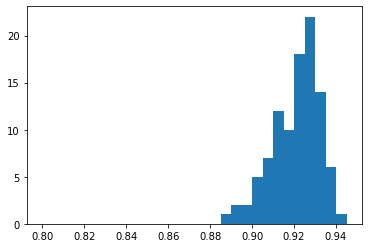

In [291]:
cl_x_dummies = pd.get_dummies(cl_x, columns=['MSZoning','LotConfig', 'BldgType', 'HouseStyle','MasVnrType', 'ExterQual', \
        'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 'BsmtExposure',
       'HeatingQC','KitchenQual','SaleCondition','BsmtFinType1','BsmtFinType2'],\
        prefix=['ms','lcf','bt','hs','mvt','eq',\
                'ec','f','bq','bc','be',\
               'hq','kq','sc','b1','b2'], prefix_sep='_',drop_first=True)
               
cl_x_dummies = cl_x_dummies.fillna(0)

trainscore = []
testscore = []

for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(cl_x_dummies, cl_y, test_size=0.2, random_state=i, shuffle=True)
        # X_train.to_csv('x_train_dummies.csv',index=False)
        # y_train.to_csv('y_train_dummies.csv',index=False)
        # X_test.to_csv('x_test_dummies.csv',index=False)
        # y_test.to_csv('y_test_dummies.csv',index=False)

        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model  = linear_model.RidgeCV(alphas=np.logspace(-3, 3, 7),normalize=True)
        model.fit(X_train, np.log(y_train))

        trainscore.append(model.score(X_train, np.log(y_train)))
        testscore.append(model.score(X_test, np.log(y_test)))

avetrainscore = np.mean(trainscore)
avetestscore = np.mean(testscore)


print(avetestscore)
plt.hist(testscore, bins = np.arange(0.8,0.95,0.005))
# plt.savefig("testscore_without_outlier.svg")

housing = clean_data.copy()
housing['residual'] = cl_y - np.exp(model.predict(cl_x_dummies))
housing.sort_values('residual')


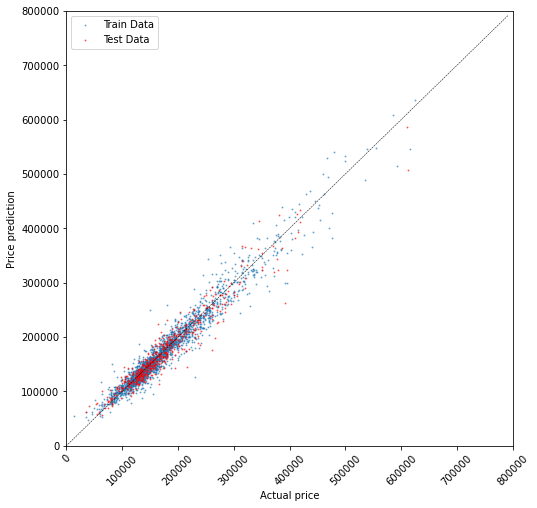

In [292]:
def abline(slope, intercept, ax):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, 'k--', linewidth=0.5)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_train, np.exp(model.predict(X_train)), alpha = 0.5, s = 1, label='Train Data')
ax.scatter(y_test, np.exp(model.predict(X_test)), alpha = 0.5, s = 1, color = 'red', label='Test Data')
abline(1,0,ax)
plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.xlabel('Actual price')
plt.ylabel('Price prediction')
plt.xticks(rotation = 45)
leg = ax.legend()

plt.show()

fig.savefig("predictresult.svg")

TypeError: pointplot() missing 1 required positional argument: 'df'

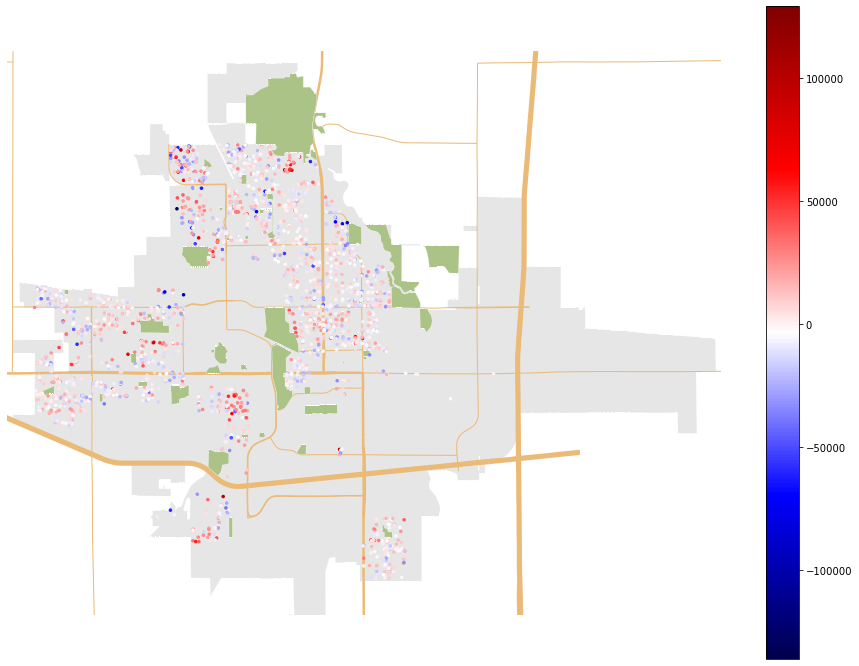

In [300]:
houses = housing.apply(
    lambda srs: Point(float(srs['Longitude']), float(srs['Latitude'])),
    axis='columns'
)
housing['pps'] = housing['SalePrice']/housing['GrLivArea']
houses_geocode = gpd.GeoDataFrame(housing, geometry=houses)

ax = geoplot.polyplot(city, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#e6e6e6', linewidth=.3, figsize=(16, 12))
geoplot.polyplot(roads_motor, edgecolor='#ebba76', linewidth=4, ax = ax)
geoplot.polyplot(roads_primary, edgecolor='#ebba76', linewidth=2.5, ax = ax)
geoplot.polyplot(roads_secondary, edgecolor='#ebba76', linewidth=1, ax = ax)
# geoplot.polyplot(roads_tertiary, edgecolor='white', linewidth=1, ax = ax)
# geoplot.polyplot(roads_residential, edgecolor='white', linewidth=0.25, ax = ax)
geoplot.pointplot(houses_geocode, hue='residual',cmap = 'seismic', marker = '.', s = 5, alpha = 1, legend=True, ax=ax)
# geoplot.pointplot(houses_geocode, hue='gaudist_Grand24',cmap = 'cool', marker = '.', s = 5, legend=True, ax=ax)
# geoplot.pointplot(houses_geocode, hue='MSSubClass',cmap = 'jet', marker = '.', s = 5, legend=True, ax=ax)

geoplot.polyplot(park, projection=gcrs.AlbersEqualArea(), edgecolor='white', facecolor='#acc388', linewidth=.3, ax=ax, extent=( -93.70,41.98, -93.52, 42.08))
geoplot.pointplot()
# plt.savefig("residual.svg")

In [293]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

xmin, xmax, nx = -93.70, -93.52, 100
ymin, ymax, ny = 41.98, 42.08, 100

x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
X2 = X.reshape(-1)
Y2 = Y.reshape(-1)
coords = pd.DataFrame(zip(X2,Y2))


for kw, val in mainlocs.items():
    dist = coords.apply(lambda x: distance.distance((x[1],x[0]), val).miles, axis = 1)
    coords['gaudist_%s' %kw] = np.exp(-(dist/1.5)**2)



In [294]:
coef = list(zip(X_train.columns.to_list(), model.coef_.T))
coef = np.array(coef)


In [297]:
Z = coords.to_numpy()[:,2:10].astype(float)@coef[19:27,1].astype(float)
Z2 = Z
Z = Z.reshape(100,100)

C:\Users\chadd\AppData\Local\Temp\ipykernel_44092\3614456696.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


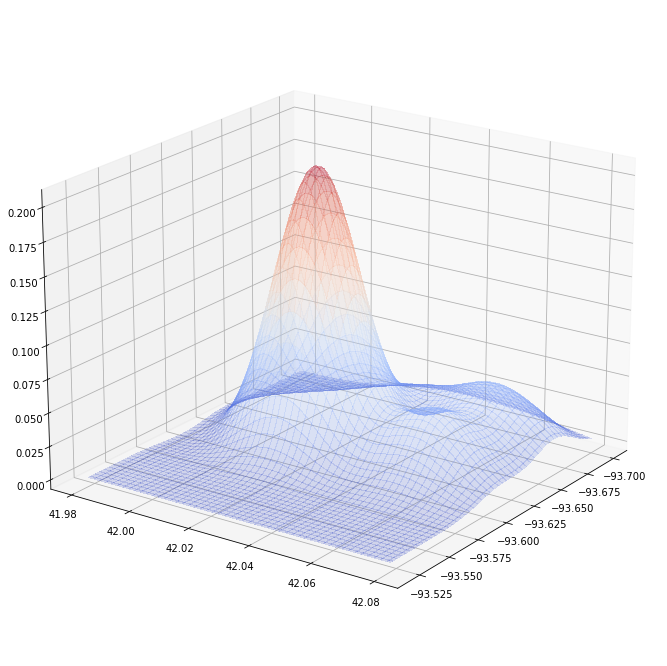

In [302]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm 

fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.2, antialiased=False)
ax.view_init(azim=0, elev=90)
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.view_init(20, 35)

